In [50]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# import data
data = import_data()

In [6]:
%%time
# preproc data
# proc
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: x.replace("<br />", " ")) # remove break symbols
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: x.lower()) # all lower case

# only use short sentences
data["len"] = data.iloc[:, 0].apply(lambda x: len(x.split()))
data = data[data["len"] < 256]

# tokenize data (split sentence into tokens)
tokenizer = Tokenizer()
print("Tokenizing the data...")
data["len"] = data.iloc[:, 0].apply(lambda x: len(tokenizer.tokenize(x)))

# only use short sentences
data = data[data["len"] < 256]

# dataset size
print("Length of the data : ", len(data))

# further proc
data.iloc[:, 0] = data.iloc[:, 0].apply(
    lambda row: re.sub("[^A-Za-z]+", " ", row)).apply(tokenizer.tokenize)

# reset index (we deleted some rows)
data = data.reset_index(drop=True)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 3min 54s
Wall time: 3min 56s


In [52]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 31.2 ms
Wall time: 21 ms


In [53]:
# create data generators
def build_generators(train, test, device, batch_size=512):
    # build vocab
    vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2}
    for item in train.iloc[:, 0]:
        for word in item:
            if word not in vocab:
                vocab[word] = len(vocab)
    pad_idx = vocab['__PAD__']
    voc_size = len(vocab)
    print("Vocabulary Size : ", voc_size)

    # create embedding
    embedding = torch.nn.Embedding(voc_size, 16)

    # dataframe to tensor
    train_y = torch.tensor(train.iloc[:, 1].values.astype(np.float32), device=device)
    test_y = torch.tensor(test.iloc[:, 1].values.astype(np.float32), device=device)

    unk_ID = vocab["__UNK__"]

    train_x_tensor = []
    for idx, text_corpus in enumerate(tqdm(train.iloc[:, 0])):
        foo = []
        for token in text_corpus:
            word_ID = vocab.get(token, unk_ID)
            foo.append(word_ID)
        while len(foo) < 256:
            foo.append(vocab["__PAD__"])
        train_x_tensor.append(foo)


    test_x_tensor = []
    for idx, text_corpus in enumerate(tqdm(test.iloc[:, 0])):
        foo = []
        for token in text_corpus:
            word_ID = vocab.get(token, unk_ID)
            foo.append(word_ID)
        while len(foo) < 256:
            foo.append(vocab["__PAD__"])
        test_x_tensor.append(foo)

    train_x = torch.tensor(train_x_tensor, device=device)
    test_x = torch.tensor(test_x_tensor, device=device)

    train = torch.utils.data.TensorDataset(train_x, train_y)
    test = torch.utils.data.TensorDataset(test_x, test_y)

    train_iterator = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
    test_iterator = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = True)

    # check imbalance
    check_imbalance(train_iterator, name='train set')
    check_imbalance(test_iterator, name='test set')

    print('Dataset initializing done')
    return train_iterator, test_iterator, voc_size, pad_idx, embedding

# CV

### Definition

In [54]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler

In [55]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch='unrestricted',
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

In [56]:
# wrapper function to optimize weighting factor
def weighted_fusion(modelA, modelB, train_iter, valid_iter, embedding, pad_idx, voc_size, device):
    def objective(trial):
        weighting_factor = trial.suggest_float('weighting_factor', 0, 1)

        # weighted fusion
        model_fusion = ot_fusion(modelA, modelB, train_iter, embedding, pad_idx, voc_size, device, fusion_ratio=weighting_factor)
        model_fusion.to(device)

        # validate fusion model
        criterion = torch.nn.CrossEntropyLoss()
        val_loss, val_acc, f1 = validation(model_fusion, valid_iter, None, criterion, device)

        return val_loss
    return objective

In [57]:
def calibrate_norm_layer(fusedModel, train_iter):
    optimizer = torch.optim.Adam(fusedModel.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    clip = 1

    fusedModel.train()
    for name, param in fusedModel.named_parameters():
        if "weight" in name or "bias" in name:
            param.requires_grad = False

    for i, batch in enumerate(tqdm(train_iter)):
        src = batch[0] # X
        trg = batch[1] # y
        src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
        optimizer.zero_grad() # reset optimizer
        output = fusedModel(src) # predict
        y_pred = torch.argmax(output, dim=-1) # logits -> labels
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg.to(torch.int64)
        loss = criterion(output_reshape, trg) # calculate loss
        agreements = torch.eq(y_pred, trg)
        accuracy = torch.mean(agreements.double()) # calculate accuracy
        loss.backward() # backward pass

        torch.nn.utils.clip_grad_norm_(fusedModel.parameters(), clip)
        optimizer.step() # optimize model

    for name, param in fusedModel.named_parameters():
        param.requires_grad = True

In [58]:
def train_last_layer(fusedModel, train_iter):
    optimizer = torch.optim.Adam(fusedModel.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    clip = 1

    fusedModel.train()
    for name, param in fusedModel.named_parameters():
        if "encoder" in name:
            param.requires_grad = False

    for i, batch in enumerate(tqdm(train_iter)):
        src = batch[0] # X
        trg = batch[1] # y
        src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
        optimizer.zero_grad() # reset optimizer
        output = fusedModel(src) # predict
        y_pred = torch.argmax(output, dim=-1) # logits -> labels
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg.to(torch.int64)
        loss = criterion(output_reshape, trg) # calculate loss
        agreements = torch.eq(y_pred, trg)
        accuracy = torch.mean(agreements.double()) # calculate accuracy
        loss.backward() # backward pass

        torch.nn.utils.clip_grad_norm_(fusedModel.parameters(), clip)
        optimizer.step() # optimize model

### Evaluation

In [59]:
scores = {'loss': {'A': [], 'B': [], 'OT_pre': [], 'OT_calibr': [], 'OT_last_layer': [], 'random': []},
          'accuracy': {'A': [], 'B': [], 'OT_pre': [], 'OT_calibr': [], 'OT_last_layer': [], 'random': []},
          'f1': {'A': [], 'B': [], 'OT_pre': [], 'OT_calibr': [], 'OT_last_layer': [], 'random': []}}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 21138.67it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\2893533748.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
Epoch: 91 - Train Loss: 0.1956 / Validation Loss: 0.4916 / Train acc: 0.9265 / Val acc: 0.8035 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:15<592:38:02,  2.13

Training has converged after 91 epochs (lr < 1e-06)


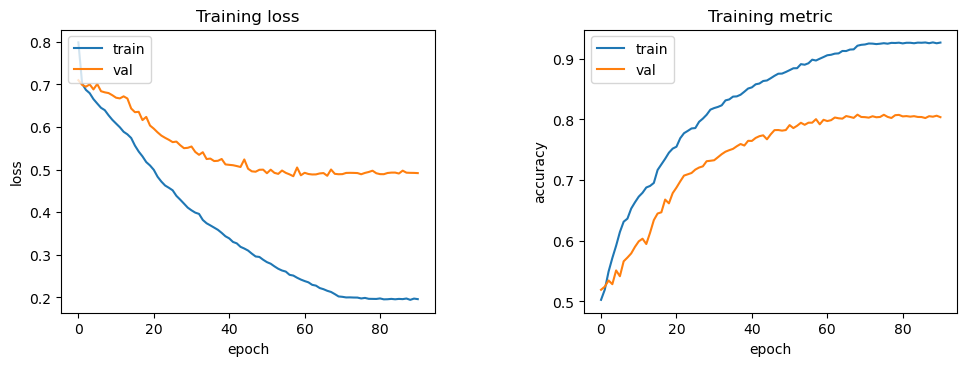

Epoch: 91 - Train Loss: 0.1956 / Validation Loss: 0.4916 / Train acc: 0.9265 / Val acc: 0.8035 / Learning Rate : 0.0000:   0%|          | 91/1000000 [03:15<596:05:36,  2.15s/it]


Starting training for model B


Epoch: 49 - Train Loss: 0.1697 / Validation Loss: 0.4232 / Train acc: 0.9374 / Val acc: 0.8368 / Learning Rate : 0.0000:   0%|          | 49/1000000 [01:45<593:56:24,  2.14s/it]

Training has converged after 49 epochs (lr < 1e-06)


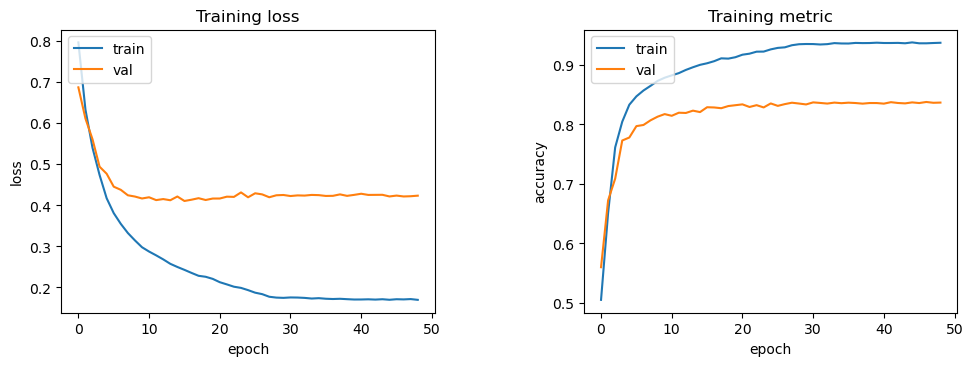

Epoch: 49 - Train Loss: 0.1697 / Validation Loss: 0.4232 / Train acc: 0.9374 / Val acc: 0.8368 / Learning Rate : 0.0000:   0%|          | 49/1000000 [01:45<600:37:52,  2.16s/it]
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful
fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


0.8404964414823903
fusion successful


  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\3778617707.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:00<00:00, 120.05it/s]


Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 22771.36it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\2893533748.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
Epoch: 92 - Train Loss: 0.1928 / Validation Loss: 0.5045 / Train acc: 0.9262 / Val acc: 0.8059 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:22<594:50:27,  2.14s/it]

Training has converged after 92 epochs (lr < 1e-06)


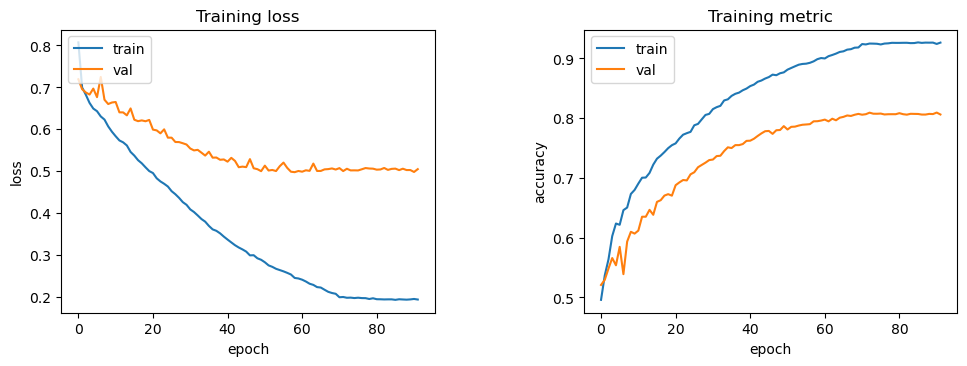

Epoch: 92 - Train Loss: 0.1928 / Validation Loss: 0.5045 / Train acc: 0.9262 / Val acc: 0.8059 / Learning Rate : 0.0000:   0%|          | 92/1000000 [03:22<610:48:45,  2.20s/it]


Starting training for model B


Epoch: 47 - Train Loss: 0.1699 / Validation Loss: 0.4270 / Train acc: 0.9385 / Val acc: 0.8357 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:41<601:07:49,  2.16s/it]

Training has converged after 47 epochs (lr < 1e-06)


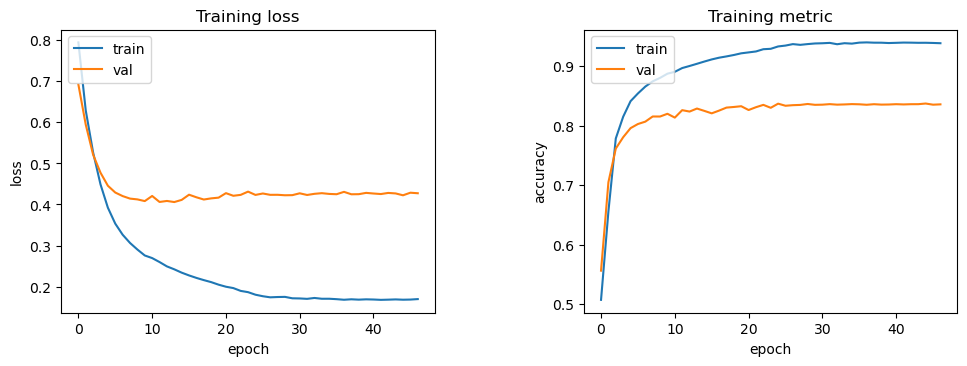

Epoch: 47 - Train Loss: 0.1699 / Validation Loss: 0.4270 / Train acc: 0.9385 / Val acc: 0.8357 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:41<600:23:00,  2.16s/it]
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful
fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


0.0004150428279789597
fusion successful


  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\3778617707.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:00<00:00, 119.60it/s]


Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 20806.92it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\2893533748.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
Epoch: 88 - Train Loss: 0.2347 / Validation Loss: 0.5443 / Train acc: 0.9092 / Val acc: 0.7794 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:11<615:40:45,  2.22s/it]

Training has converged after 88 epochs (lr < 1e-06)


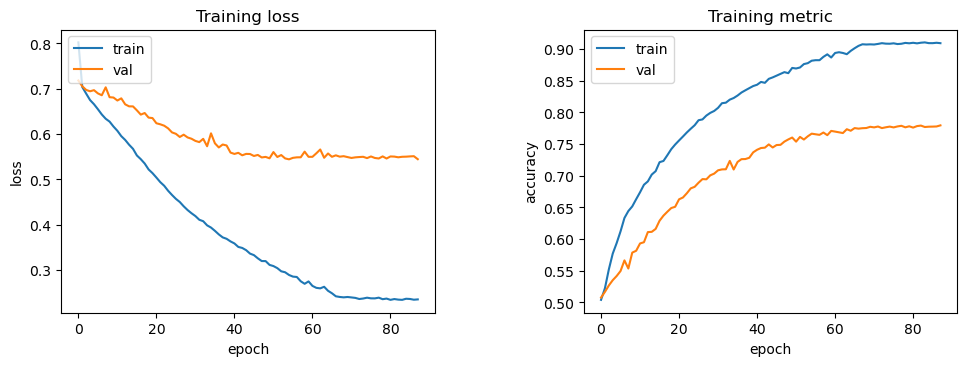

Epoch: 88 - Train Loss: 0.2347 / Validation Loss: 0.5443 / Train acc: 0.9092 / Val acc: 0.7794 / Learning Rate : 0.0000:   0%|          | 88/1000000 [03:12<606:22:41,  2.18s/it]


Starting training for model B


Epoch: 45 - Train Loss: 0.2082 / Validation Loss: 0.4592 / Train acc: 0.9218 / Val acc: 0.8122 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:36<602:16:11,  2.17s/it]

Training has converged after 45 epochs (lr < 1e-06)


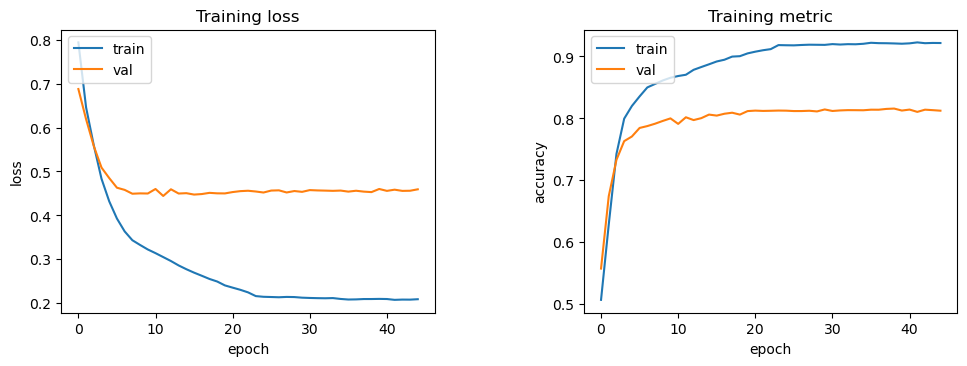

Epoch: 45 - Train Loss: 0.2082 / Validation Loss: 0.4592 / Train acc: 0.9218 / Val acc: 0.8122 / Learning Rate : 0.0000:   0%|          | 45/1000000 [01:36<597:47:10,  2.15s/it]
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful
fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


0.2145477348925104
fusion successful


  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\3778617707.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:00<00:00, 120.06it/s]


Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 23402.64it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\2893533748.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
Epoch: 83 - Train Loss: 0.1990 / Validation Loss: 0.4942 / Train acc: 0.9257 / Val acc: 0.8064 / Learning Rate : 0.0000:   0%|          | 83/1000000 [02:57<595:44:36,  2.14s/it]

Training has converged after 83 epochs (lr < 1e-06)


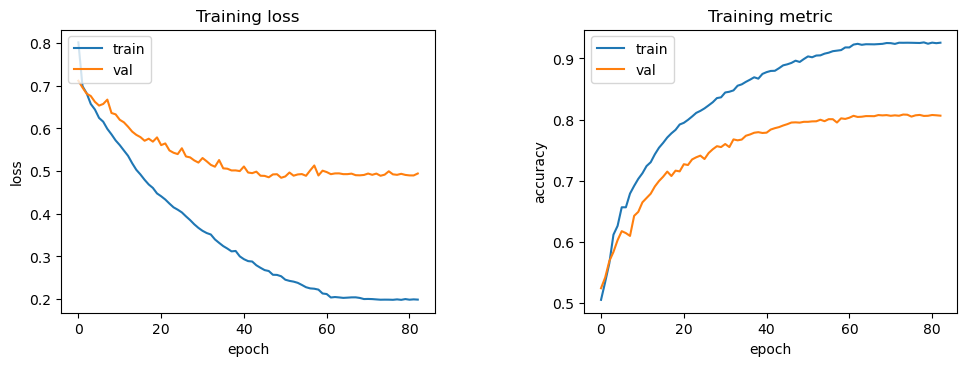

Epoch: 83 - Train Loss: 0.1990 / Validation Loss: 0.4942 / Train acc: 0.9257 / Val acc: 0.8064 / Learning Rate : 0.0000:   0%|          | 83/1000000 [02:57<594:05:48,  2.14s/it]


Starting training for model B


Epoch: 47 - Train Loss: 0.1666 / Validation Loss: 0.4265 / Train acc: 0.9398 / Val acc: 0.8349 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:40<591:20:50,  2.13s/it]

Training has converged after 47 epochs (lr < 1e-06)


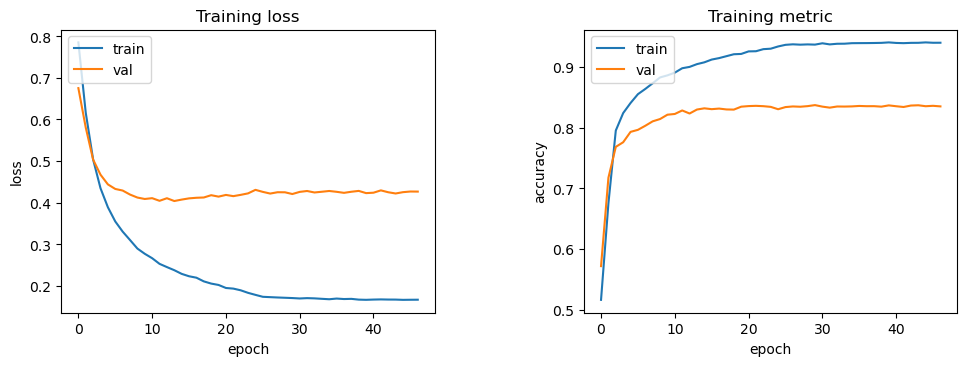

Epoch: 47 - Train Loss: 0.1666 / Validation Loss: 0.4265 / Train acc: 0.9398 / Val acc: 0.8349 / Learning Rate : 0.0000:   0%|          | 47/1000000 [01:40<594:46:08,  2.14s/it]
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful
fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


0.8728390356374165
fusion successful


  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\3778617707.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:00<00:00, 119.44it/s]


Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22131.82it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\2893533748.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu
Epoch: 84 - Train Loss: 0.2025 / Validation Loss: 0.4986 / Train acc: 0.9225 / Val acc: 0.7997 / Learning Rate : 0.0000:   0%|          | 84/1000000 [02:59<589:22:34,  2.12s/it]

Training has converged after 84 epochs (lr < 1e-06)


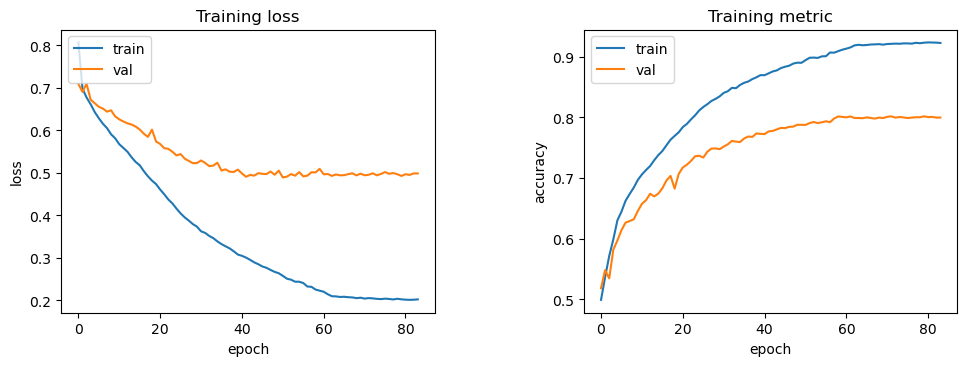

Epoch: 84 - Train Loss: 0.2025 / Validation Loss: 0.4986 / Train acc: 0.9225 / Val acc: 0.7997 / Learning Rate : 0.0000:   0%|          | 84/1000000 [02:59<594:35:19,  2.14s/it]


Starting training for model B


Epoch: 44 - Train Loss: 0.1810 / Validation Loss: 0.4161 / Train acc: 0.9320 / Val acc: 0.8325 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:34<593:41:11,  2.14s/it]

Training has converged after 44 epochs (lr < 1e-06)


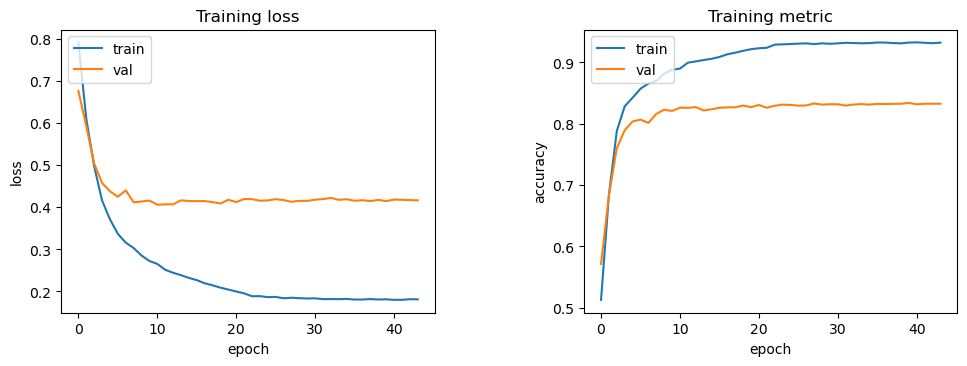

Epoch: 44 - Train Loss: 0.1810 / Validation Loss: 0.4161 / Train acc: 0.9320 / Val acc: 0.8325 / Learning Rate : 0.0000:   0%|          | 44/1000000 [01:34<595:28:50,  2.14s/it]
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful
fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful
0.17276267540779028


C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Deep Learning\Exploring Model Fusion with Optimal Transport on Transformers\utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device)  # put to cpu/gpu


fusion successful


  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\3778617707.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:00<00:00, 116.63it/s]


CPU times: total: 29min 56s
Wall time: 25min 32s


In [60]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        print('Starting training for model A')
        modelA = train_early_stopping(model_name='A',
                                      train_iter=train_iterator,
                                      valid_iter=test_iterator,
                                      embedding=embedding,
                                      pad_idx=pad_idx,
                                      voc_size=voc_size,
                                      device=device,
                                      lr=LEARNING_RATE,
                                      save=False)
        print('Starting training for model B')
        modelB = train_early_stopping(model_name='B',
                                      train_iter=train_iterator,
                                      valid_iter=test_iterator,
                                      embedding=embedding,
                                      pad_idx=pad_idx,
                                      voc_size=voc_size,
                                      device=device,
                                      lr=LEARNING_RATE,
                                      save=False)

        # model fusion
        # 2) optimal transport
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device), n_trials=50)
        best_weighting_factor = study.best_params['weighting_factor']
        print(best_weighting_factor)
        model_fusion = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor)

        # evaluate
        # ensure all models on same device
        modelA = modelA.to(device)
        modelB = modelB.to(device)
        model_random = new_model(embedding, pad_idx, voc_size, device)
        model_fusion = model_fusion.to(device)

        # test models
        scoresA = validation(modelA, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scoresB = validation(modelB, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scores_random = validation(model_random, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        scores_fusion = validation(model_fusion, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

        # put into cpu
        for name, scores_ in zip(('A', 'B', 'random', 'OT_pre'), (scoresA, scoresB, scores_random, scores_fusion)):
            loss, acc, f1 = scores_

            loss = loss.to('cpu') if isinstance(loss, torch.Tensor) else loss
            acc = acc.to('cpu') if isinstance(acc, torch.Tensor) else acc
            f1 = f1.to('cpu') if isinstance(f1, torch.Tensor) else f1

            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # recalibration
        calibrate_norm_layer(model_fusion, train_iterator)

        # evaluate
        scores_fusion = validation(model_fusion, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        loss, acc, f1 = scores_fusion
        loss = loss.to('cpu') if isinstance(loss, torch.Tensor) else loss
        acc = acc.to('cpu') if isinstance(acc, torch.Tensor) else acc
        f1 = f1.to('cpu') if isinstance(f1, torch.Tensor) else f1
        name = 'OT_calibr'
        scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)


        # retraining last layer
        # 2) optimal transport
        train_last_layer(model_fusion, train_iterator)

        # evaluate
        scores_fusion = validation(model_fusion, test_iterator, None, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)
        loss, acc, f1 = scores_fusion
        loss = loss.to('cpu') if isinstance(loss, torch.Tensor) else loss
        acc = acc.to('cpu') if isinstance(acc, torch.Tensor) else acc
        f1 = f1.to('cpu') if isinstance(f1, torch.Tensor) else f1
        name = 'OT_last_layer'
        scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [68]:
df = pd.DataFrame.from_dict(scores)

In [69]:
# entries like: mean +- std
n_rows, n_cols = df.shape
for row in range(n_rows):
    df.iloc[row, 0] = str(np.round(np.mean(df.iloc[row, 0]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 0]), 3)) # loss
    df.iloc[row, 1] = str(np.round(np.mean(df.iloc[row, 1]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 1]), 3)) # accuracy
    df.iloc[row, 2] = str(np.round(np.mean(df.iloc[row, 2]), 3)) + ' ± ' + str(np.round(np.std(df.iloc[row, 2]), 3)) # f1

In [70]:
# rename rows, cols
df.columns = ['Loss', 'Accuracy', 'F1 score']
df.index = ['Model A', 'Model B', 'Optimal transport + weighted fusion', 'OT + weighted fusion (recalibrated)',
            'OT + weighted fusion (last layer retrained)', 'Untrained model (baseline)']

In [71]:
# boldify highest score
for col in (0, 1, 2):
    if col == 0:
        index_max = np.argmin([float(entry.split('±')[0]) for entry in df.iloc[:, col]])
    else:
        index_max = np.argmax([float(entry.split('±')[0]) for entry in df.iloc[:, col]])
    entry = df.iloc[index_max, col]
    entry = 'BOLD{' + entry + '}'
    df.iloc[index_max, col] = entry

In [72]:
# convert to latex
latex = df.to_latex(index=True,
                    bold_rows=True,
                    caption='Model performance (5-fold CV)',
                    position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')

C:\Users\jjung\AppData\Local\Temp\ipykernel_33188\1498540714.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=True,


In [73]:
# print as latex
print(latex)

\begin{table}[H]
\centering
\caption{Model performance (5-fold CV)}
\begin{tabular}{llll}
\toprule
{} &                 Loss &             Accuracy &            F1 score \\
\midrule
\textbf{Model A                                    } &         0.47 ± 0.021 &        0.821 ± 0.013 &       0.821 ± 0.013 \\
\textbf{Model B                                    } &  \textbf{0.433 ± 0.014} &  \textbf{0.829 ± 0.009} &  \textbf{0.83 ± 0.009} \\
\textbf{Optimal transport + weighted fusion        } &        0.909 ± 0.454 &        0.692 ± 0.086 &       0.692 ± 0.086 \\
\textbf{OT + weighted fusion (recalibrated)        } &         0.63 ± 0.183 &        0.711 ± 0.072 &       0.711 ± 0.072 \\
\textbf{OT + weighted fusion (last layer retrained)} &        0.766 ± 0.423 &        0.688 ± 0.108 &       0.688 ± 0.108 \\
\textbf{Untrained model (baseline)                 } &        0.758 ± 0.042 &        0.506 ± 0.005 &       0.506 ± 0.006 \\
\bottomrule
\end{tabular}
\end{table}



In [74]:
# save as latex (in text format)
with open('./Output/scores_different_seeds_weighted_fusion.txt','w') as dat:
    dat.write(str(latex))